In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from pathlib import Path
import re

In [36]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 17,
    "axes.titlesize": 22,
    "axes.labelsize": 19,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
})

In [37]:
df_ngb = pd.read_csv("../data/model_results.csv")
nesvorny_elements = pd.read_csv("../data/nesvorny_catalog_dataset.csv")
df_ngb = pd.merge(df_ngb, nesvorny_elements[["Des'n", 'a', 'da', 'de', 'dsini']], on="Des'n", how="inner")

/tmp/ipykernel_53197/3022341705.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  nesvorny_elements = pd.read_csv("../data/nesvorny_catalog_dataset.csv")


In [38]:
propa = df_ngb["propa"]
prope = df_ngb["prope"]
propsini = df_ngb["propsini"]

test_name_list = df_ngb['Des\'n']

In [39]:
def histogram_generation(d_cutoff, family_df):
    def convert_id(val):
        val_str = str(val)
        if val_str.isdigit():
            return int(val_str)
        return val_str
    family_df["PackedName"] = family_df["PackedName"].apply(convert_id)
    name_list = family_df["PackedName"]
    family_df = nesvorny_elements[nesvorny_elements["Des'n"].isin(name_list)]
    family_pred_df = df_ngb[df_ngb["Des'n"].isin(name_list)]
    # Calculate the percentage of machine learning prediction still classifies asteroids into the family
    family_pred_df = df_ngb[df_ngb["Des'n"].isin(name_list)]
    def calculate_d(a_p, delta_a_p, delta_e_p, delta_sin_i_p):
        numerator = 3e4  # 3 × 10^4 m/s
        denominator = math.sqrt(a_p)
        term1 = (delta_a_p / a_p) ** 2
        term2 = 2 * (delta_e_p ** 2)
        term3 = 2 * (delta_sin_i_p ** 2)
        inside_sqrt = (5 / 4) * term1 + term2 + term3
        d = (numerator / denominator) * math.sqrt(inside_sqrt)
        return d
    
    # create a slab enclosing all family members
    def slab_d_calc(family_df_copy, family_pred_df_copy, merged_df, command):
        if command == "osculating":
            columns_bound = {"a": "a", "e": "e", "sini": "Incl."}
            columns = {"a": "a", "e": "e", "sini": "Incl."}
        elif command == "proper":
            columns_bound = {"a": "propa", "e": "prope", "sini": "propsini"}
            columns = {"a": "propa", "e": "prope", "sini": "propsini"}
        elif command == "pred":
            # family_df_copy = family_pred_df_copy
            columns_bound = {"a": "propa", "e": "prope", "sini": "propsini"}
            columns = {"a": "propa", "e": "pred_e", "sini": "pred_sini"}

        adds = 0

        a_adds = (family_df_copy[columns_bound["a"]].max() - family_df_copy[columns_bound["a"]].min())/2
        e_adds = (family_df_copy[columns_bound["e"]].max() - family_df_copy[columns_bound["e"]].min())/2
        sini_adds = (family_df_copy[columns_bound["sini"]].max() - family_df_copy[columns_bound["sini"]].min())/2

        a_adds = 0
        e_adds = 0
        sini_adds = 0

        a_min, a_max = family_df_copy[columns_bound["a"]].min() - a_adds, family_df_copy[columns_bound["a"]].max() + a_adds
        e_min, e_max = family_df_copy[columns_bound["e"]].min() - e_adds, family_df_copy[columns_bound["e"]].max() + e_adds
        sini_min, sini_max = family_df_copy[columns_bound["sini"]].min() - sini_adds, family_df_copy[columns_bound["sini"]].max() + sini_adds

        slab_df = merged_df[
            (merged_df[columns["a"]] >= a_min) & (merged_df[columns["a"]] <= a_max) &
            (merged_df[columns["e"]] >= e_min) & (merged_df[columns["e"]] <= e_max) &
            (merged_df[columns["sini"]] >= sini_min) & (merged_df[columns["sini"]] <= sini_max)
        ]

        a_family, e_family, sini_family, names = family_df_copy[columns_bound["a"]].values, family_df_copy[columns_bound["e"]].values, family_df_copy[columns_bound["sini"]].values, family_df_copy["Des'n"].values
        
        d_results = []
        for idx, row in slab_df.iterrows():
            a = row[columns["a"]]
            e = row[columns["e"]]
            sini = row[columns["sini"]]
            name = row["Des'n"]
            
            for a_f, e_f, sini_f, name_f in zip(a_family, e_family, sini_family, names):
                if name == name_f:
                    continue
                else:
                    da = a_f - a
                    de = e_f - e
                    dsini = sini_f - sini
                    d = calculate_d(a, da, de, dsini)
                    d_results.append({
                        "name_asteroid": name,
                        "name_family_asteroid": name_f,
                        "d": d
                    })
        d_df = pd.DataFrame(d_results)

        return d_df
        
    d_df = slab_d_calc(family_df, family_pred_df, df_ngb, "pred")
    d_df_single = d_df.drop_duplicates(subset = ["name_asteroid"])
    num_family_slab = len(d_df_single[d_df_single["name_asteroid"].isin(name_list)])
    filtered_df = d_df[d_df["d"] < float(d_cutoff.iloc[0])]
    filtered_df = filtered_df.drop_duplicates(subset = ["name_asteroid"])
    family_slab_df = filtered_df[filtered_df["name_asteroid"].isin(name_list)]

    return len(family_slab_df), num_family_slab, len(filtered_df)

In [40]:
import pandas as pd
import glob
import io  # <-- use this

def extract_table_from_txt(path):
    """Extracts the table portion from one ASCII file and returns a DataFrame."""
    with open(path, "r") as f:
        lines = f.readlines()

    # Find start of table
    start = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Number"):
            start = i
            break

    # Find end of table
    end = None
    for i, line in enumerate(lines[start:], start=start):
        if line.strip().startswith("Note."):
            end = i
            break

    # Slice out table lines
    table_lines = lines[start:end]

    # Read into DataFrame
    df = pd.read_csv(io.StringIO("".join(table_lines)), sep="\t+", engine="python")
    return df

# Collect all txt files in your folder
all_files = glob.glob("../family_d_vals/*.txt")

# Extract and merge
df_list = [extract_table_from_txt(file) for file in all_files]
df_d = pd.concat(df_list, ignore_index=True)

In [41]:
dataset_path = Path('../family_tables')
filenames = list(dataset_path.glob('*.csv'))
name_list = []
total_family_list = []
true_family_list = []
detected_family_list = []

In [42]:
df_d

,Number,Name,HCM Cut,Number of Members,Notes
0,174,Phaedra,60,170,"diffuse, S-type"
1,321,Florentina,10,209,"Koronis_4 in Broz et al. (2024), HCM cut"
2,392,Wilhelmina,40,45,"compact, C-type"
3,924,Toni,50,50,"compact, C-type"
4,1289,Kutaisii,10,371,Koronis_3 in Broz et al. (2024)
...,...,...,...,...,...
148,54934,2001 OH105,50,37,small bodies
149,190237,2007 DM10,50,41,small
150,249576,1995 FH2,30,78,"diffuse, C-type"
151,435544,2008 OV23,20,90,"in Eunomia, compact, small bodies"


In [43]:
def change_asteroid_name(name):
    if isinstance(name, str):
        first_part = name.split(' ')[0]
        match = re.match(r'^(?P<year>\d{4})(?P<letters>[a-zA-Z]+)(?P<numbers>\d+)$', name)
        if first_part.isdigit() or name.replace('.', '').isdigit():
            return name
        if match:
            year = match.group('year')
            letters = match.group('letters').upper() # Capitalize all letters
            numbers = match.group('numbers')
            return f"{year} {letters}{numbers}"
        else:
            return name.title()
    return name

column_names = ['propa', 'prope', 'propsini', 'g', 's', 'H', 'NumOpps', 'PackedName', 'UnpackedName']
for filename in filenames:
    try:
        df_family = pd.read_csv(str(filename), header = None, names = column_names)
        family_name = str(filename).split("/")[-1].split(".")[0].split("_")[-2]
        family_name = change_asteroid_name(family_name)
        d = df_d[df_d["Name"] == family_name]["HCM Cut"]
        number = df_d[df_d["Name"] == family_name]["Number of Members"]
        if number.iloc[0] > 50:
            true_family, total_family, detected_family = histogram_generation(d, df_family)
            name_list.append(filename)
            true_family_list.append(true_family)
            total_family_list.append(total_family)
            detected_family_list.append(detected_family)
        else: 
            continue
    except Exception as e:
        # This is a general catch-all for any other unexpected errors
        print(f"An unexpected error occurred while processing '{filename}': {e}. Skipping.")

An unexpected error occurred while processing '../family_tables/inner_2110_moore_sitterly_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/middle_1048_feodosia_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/outer_37455_4727p_l_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/inner_70208_1999rx33_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/inner_2823_vanderlaan_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/inner_1663_vandenbos_fam3.csv': single positional indexer is out-of-bounds. Skipping.
An unexpected error occurred while processing '../family_tables/middle_351_yrsa_fam3.csv': sing

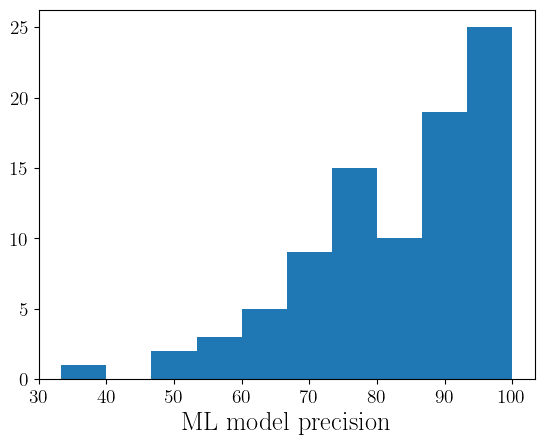

In [47]:
# Generate the plot for precision in identifying family members
plt.hist(np.array(true_family_list)/np.array(detected_family_list) * 100)
plt.xlabel("ML model precision")
plt.savefig("../plots/Precision_plot.pdf", bbox_inches=None)
plt.show()

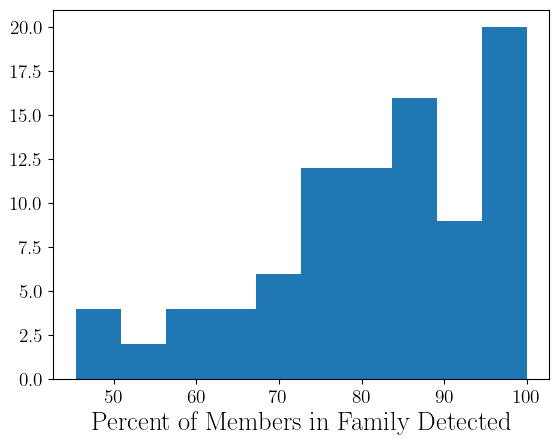

In [45]:
# Generate the plot for percent of family members detected
plt.hist(np.array(true_family_list)/np.array(total_family_list) * 100)
plt.xlabel("Percent of Members in Family Detected")
plt.savefig("../plots/Percent_detected_plot.pdf")

In [46]:
# print out the family that model has a low precision to identify out
precision = np.array(true_family_list)/np.array(detected_family_list) * 100
indices = [i for i, val in enumerate(precision) if val < 50]
for i in indices:
    print(name_list[i])

../family_tables/pristine_321_florentina_fam3.csv
